# Exercise 2: Intro to embeddings

In this exercise---inspired by  [Wulff & Mata, 2023](https://osf.io/preprints/psyarxiv/9h7aw)---we will use an LLM to extract features (embeddings) from personality items. We will then use these features to compute the similarity between items, evaluate how well these predict observed similarities, and visualize the similarity matrix in two dimensions. Finally, we will assign each item to a personality construct based on its similarity to the constructs.

By the end of this analysis, you will have learned how:
- To extract features from text using an LLM
- To compute the similarity between items using cosine similarity
- How this can be used to predict the construct to which an item belongs, and thus potentially improve construct validity

## Environment Setup 

In [1]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Installing requisite packages
    !pip install pacmap sentence-transformers &> /dev/null

    # Change working directory 
    %cd /content/drive/MyDrive/LLM4Psych_DGPS2024/exercise_2

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity # for machine learning
from sentence_transformers import SentenceTransformer
from pacmap import PaCMAP
import seaborn as sns # for creating plots
import matplotlib.pyplot as plt

c:\Users\fenn\AppData\Local\R-MINI~1\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Extracting Features from Personality Items

We begin by loading the personality items into a `pandas.DataFrame` with three columns:

1. `factor`: The (high-level) personality factor to which the item belongs.
2. `construct`: The (mid-level) personality construct to which the item belongs.
3. `item`: The text of the personality item used to measure the construct.

Run the cell below.

In [3]:
# Loading personality data
personality = pd.read_csv('items.csv') 
personality

,factor,construct,item
0,Conscientiousness,Achievement-Striving,Go straight for the goal.
1,Conscientiousness,Achievement-Striving,Plunge into tasks with all my heart.
2,Conscientiousness,Achievement-Striving,Demand quality.
3,Conscientiousness,Achievement-Striving,Set high standards for myself and others.
4,Conscientiousness,Achievement-Striving,Turn plans into actions.
...,...,...,...
295,Neuroticism,Vulnerability,Remain calm under pressure.
296,Neuroticism,Vulnerability,Am calm even in tense situations.
297,Neuroticism,Vulnerability,Can handle complex problems.
298,Neuroticism,Vulnerability,Readily overcome setbacks.


The code below makes use of the `all-MiniLM-L6-v2` model to extract features from the personality items. It loads the model using the `sentence_transformers` library and extracts a vector of features for each item with the `encode` method. It then converts the features to a `pandas.DataFrame` for further analysis and for easy viewing.

Run the cell below.

In [4]:
# Load pre-trained model
# model = SentenceTransformer('all-MiniLM-L6-v2')  
model = SentenceTransformer('dwulff/mpnet-personality')

# Extract features from personality items
item_features = model.encode(personality['item'])

# Convert features to DataFrame
item_features = pd.DataFrame(item_features, index=personality['item'])
item_features

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
item,,,,,,,,,,,,,,,,,,,,,
Go straight for the goal.,-0.018780,-0.041592,0.063181,-0.022643,0.118072,-0.057340,-0.046655,-0.013076,-0.102702,0.007447,...,-0.017813,0.005277,-0.001056,-0.020201,-0.005818,-0.054473,-0.023909,0.001882,-0.007007,-0.011683
Plunge into tasks with all my heart.,-0.035980,-0.036059,-0.001261,0.006356,0.039660,-0.015887,-0.029266,-0.025641,-0.044656,0.039313,...,-0.028352,0.004307,-0.062879,0.000613,-0.005144,-0.100453,-0.058041,0.023636,0.004513,0.018006
Demand quality.,-0.009666,0.035122,0.031397,0.023375,0.058045,-0.070009,0.046002,0.021952,-0.082185,0.025860,...,0.016274,0.085180,0.034887,0.015498,-0.070713,-0.048674,-0.007990,0.015191,0.023085,-0.004371
Set high standards for myself and others.,-0.054333,-0.013227,0.014020,-0.000667,0.048780,-0.036437,-0.018918,0.005098,-0.000009,-0.047885,...,-0.022017,0.044900,0.015969,0.015136,0.007367,-0.031895,-0.036067,-0.017557,-0.000537,0.022647
Turn plans into actions.,-0.003898,-0.028290,0.002586,0.020336,0.064410,-0.014253,-0.056374,-0.013619,-0.111752,0.042088,...,-0.010572,-0.008337,-0.013198,0.016060,-0.005081,0.035054,-0.006708,0.046634,-0.036381,-0.013510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Remain calm under pressure.,-0.022304,-0.059622,0.013942,-0.009734,0.042124,0.006676,-0.020342,0.057162,-0.063691,0.069322,...,-0.021849,-0.025425,0.003873,0.039260,-0.037454,-0.038715,-0.021140,-0.047551,0.025035,-0.011241
Am calm even in tense situations.,-0.062405,-0.115509,0.009995,0.034117,0.026099,-0.007364,0.002127,0.059007,-0.063723,0.036711,...,-0.002279,0.018229,0.048556,-0.014066,-0.004403,0.000053,-0.005237,-0.030038,0.035436,-0.006427
Can handle complex problems.,-0.035285,-0.038498,-0.005008,0.014943,0.037639,0.005376,0.059381,0.013403,-0.051023,0.021139,...,0.001161,0.028313,0.003592,0.018175,-0.072247,-0.073248,-0.010977,0.018910,-0.033361,-0.001394


## Computing Similarity between Personality Items
Now that we have extracted features for each personality item, we can compute the similarity between items. We use the `sklearn`'s `cosine similarity` function, which measures the cosine of the angle between two vectors. The closer the cosine similarity is to 1, the more similar the two items are. We compute the similarity between all pairs of items and store the results in a similarity matrix.

Run the cell below.

In [5]:
# Compute cosine similarity between features
predicted_sims = cosine_similarity(item_features)
predicted_sims = pd.DataFrame(predicted_sims, index=personality['item'], columns=personality['item'])
predicted_sims

item,Go straight for the goal.,Plunge into tasks with all my heart.,Demand quality.,Set high standards for myself and others.,Turn plans into actions.,Do more than what's expected of me.,Work hard.,Do just enough work to get by.,Am not highly motivated to succeed.,Put little time and effort into my work.,...,Panic easily.,Get overwhelmed by emotions.,Feel that I'm unable to deal with things.,Can't make up my mind.,Become overwhelmed by events.,Remain calm under pressure.,Am calm even in tense situations.,Can handle complex problems.,Readily overcome setbacks.,Know how to cope.
item,,,,,,,,,,,,,,,,,,,,,
Go straight for the goal.,1.000000,0.322911,0.189057,0.282260,0.403760,0.294488,0.379704,0.272602,0.320595,0.204176,...,0.126379,0.179802,0.237034,0.297587,0.158859,0.213267,0.188119,0.216429,0.241277,0.214431
Plunge into tasks with all my heart.,0.322911,1.000000,0.153491,0.290017,0.358438,0.415686,0.364594,0.321410,0.259298,0.259998,...,0.057035,0.078839,0.107214,0.148253,0.108816,0.120974,0.090421,0.186992,0.238656,0.151397
Demand quality.,0.189057,0.153491,1.000000,0.450911,0.164963,0.209361,0.214776,0.127016,0.139491,0.139850,...,0.032018,0.044593,0.065228,0.113834,0.039337,0.069712,0.057152,0.240216,0.091520,0.066419
Set high standards for myself and others.,0.282260,0.290017,0.450911,1.000000,0.289751,0.428175,0.331843,0.240042,0.317425,0.274426,...,0.041718,0.033612,0.098762,0.150564,0.082874,0.116305,0.090180,0.248244,0.176827,0.147204
Turn plans into actions.,0.403760,0.358438,0.164963,0.289751,1.000000,0.368896,0.346935,0.306967,0.303932,0.239690,...,0.203196,0.169962,0.343579,0.283827,0.275311,0.239381,0.220197,0.290601,0.339399,0.337360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Remain calm under pressure.,0.213267,0.120974,0.069712,0.116305,0.239381,0.173353,0.206050,0.173035,0.171452,0.142994,...,0.632029,0.424928,0.321502,0.376206,0.483241,1.000000,0.652828,0.428015,0.400207,0.432643
Am calm even in tense situations.,0.188119,0.090421,0.057152,0.090180,0.220197,0.085194,0.078459,0.084685,0.085526,0.101019,...,0.523954,0.347597,0.309969,0.236318,0.345287,0.652828,1.000000,0.316289,0.327950,0.358620
Can handle complex problems.,0.216429,0.186992,0.240216,0.248244,0.290601,0.277738,0.222882,0.263991,0.203810,0.187910,...,0.314284,0.226276,0.266616,0.285602,0.332771,0.428015,0.316289,1.000000,0.335525,0.337701


As you can see, the similarity matrix is symmetric, with the diagonal containing 1s (since the similarity of an item with itself is 1). Furthermore, items that you would expect to be more related (e.g. `"Turn plans into actions"` and `"Plunge into tasks with all my heart."`) are indeed more similar. Conversely, less related items (e.g. `"Am calm in tense situations"` and `"Demand quality"`) show lower cosine similarities.

 ## Comparing to observed correlations between items
This section compares how well the predicted similarities align with the *observed* similarities between items: that is, the correlations between the participant responses to the items. It first loads the observed correlations into a `pandas.DataFrame`:

In [6]:
# Load observed correlations
observed_sims = pd.read_csv('item_corrs.csv')
observed_sims

,text_i,text_j,cor
0,Worry about things.,Worry about things.,1.000000
1,Make friends easily.,Worry about things.,-0.092088
2,Have a vivid imagination.,Worry about things.,0.011413
3,Trust others.,Worry about things.,-0.122167
4,Complete tasks successfully.,Worry about things.,-0.052228
...,...,...,...
89995,Am calm even in tense situations.,Often make last-minute plans.,0.031644
89996,Seldom joke around.,Often make last-minute plans.,-0.143314
89997,Like to stand during the national anthem.,Often make last-minute plans.,-0.023413
89998,Can't stand weak people.,Often make last-minute plans.,0.038725


Next, the code pivots `observed_sims` to create a correlation matrix with the same structure as `predicted_sims` so that they can be easily compared.

In [7]:
# Pivoting to a correlation matrix for easy comparison with predicted correlations
observed_sims = observed_sims.pivot(index='text_i', columns='text_j', values='cor')
observed_sims

text_j,Act comfortably with others.,Act wild and crazy.,Act without thinking.,Adapt easily to new situations.,Am a creature of habit.,Am able to control my cravings.,Am able to stand up for myself.,Am afraid of many things.,Am afraid that I will do the wrong thing.,Am afraid to draw attention to myself.,...,Want everything to be just right.,Want to be left alone.,Warm up quickly to others.,Waste my time.,Willing to try anything once.,Work hard.,Worry about things.,Would never cheat on my taxes.,Would never go hang gliding or bungee jumping.,Yell at people.
text_i,,,,,,,,,,,,,,,,,,,,,
Act comfortably with others.,1.000000,0.217360,0.012991,-0.430405,0.101136,-0.104918,-0.303101,-0.245115,-0.229300,-0.393090,...,-0.021545,0.407432,0.519459,0.193105,0.158005,0.162693,-0.162281,0.029572,0.124640,0.090932
Act wild and crazy.,0.217360,1.000000,-0.421215,-0.177011,0.134400,0.101634,-0.126245,-0.028102,-0.040210,-0.276224,...,-0.070427,0.175862,0.213489,-0.113697,0.317553,-0.097946,-0.076365,-0.115061,0.294004,-0.230751
Act without thinking.,0.012991,-0.421215,1.000000,-0.023407,-0.024389,-0.240195,-0.072953,-0.154781,-0.133205,0.055036,...,0.047438,0.012868,-0.069470,0.308881,-0.188441,0.217708,-0.050914,0.132766,-0.137169,0.327725
Adapt easily to new situations.,-0.430405,-0.177011,-0.023407,1.000000,-0.222098,0.153603,0.343191,0.359561,0.278076,0.328830,...,0.105141,-0.249252,-0.314628,-0.169759,-0.257563,-0.143309,0.260600,0.019874,-0.192907,-0.120178
Am a creature of habit.,0.101136,0.134400,-0.024389,-0.222098,1.000000,-0.065602,-0.100340,-0.169118,-0.155461,-0.156853,...,-0.222918,0.140241,0.077795,0.057557,0.132251,-0.029368,-0.163692,-0.042522,0.154302,0.049869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Work hard.,0.162693,-0.097946,0.217708,-0.143309,-0.029368,-0.168711,-0.162225,-0.115883,-0.075400,-0.040886,...,0.160276,0.106788,0.094098,0.422429,0.002044,1.000000,0.027527,0.159320,-0.016483,0.113103
Worry about things.,-0.162281,-0.076365,-0.050914,0.260600,-0.163692,0.144669,0.204268,0.431686,0.408099,0.198018,...,0.239192,-0.107536,-0.078245,-0.074586,-0.107065,0.027527,1.000000,0.051653,-0.143831,-0.136540
Would never cheat on my taxes.,0.029572,-0.115061,0.132766,0.019874,-0.042522,-0.103727,0.021737,0.030539,0.060323,0.083540,...,0.072984,0.056801,0.049876,0.137484,-0.088864,0.159320,0.051653,1.000000,-0.067971,0.115916


The predicted and observed similarities are then aligned to ensure that the items are in the same order. The code then flattens the lower triangle of the matrices into vectors to compute the correlation between the predicted and observed similarities.

In [8]:
# Aligning observed and predicted similarities
predicted_sims, observed_sims = predicted_sims.align(observed_sims)

def lower_triangle_flat(df):
    """Takes the lower triangle of a dataframe and flattens it into a vector"""
    rows, cols = np.triu_indices(len(df), k=1)  # k=1 to exclude the diagonal (self-similarities)
    return pd.Series(df.values[rows, cols])

# Flatten the lower triangle of the observed and predicted similarities into vectors
predicted_sims_flat, observed_sims_flat = lower_triangle_flat(predicted_sims), lower_triangle_flat(observed_sims)

# Correlation between predicted and observed
print(f'r: {predicted_sims_flat.corr(observed_sims_flat).round(2)}')
print(f'r of absolute values: {predicted_sims_flat.abs().corr(observed_sims_flat.abs()).round(2)}')

r: 0.37
r of absolute values: 0.95


The correlation between the predicted and observed similarities is 0.18. If we take the absolute values of the similarities, the correlation increases to 0.33. Since we are not interested in which way round (in terms of polarity) the personality item scale was rated, we focus on the absolute values. This suggests that the extracted features capture some of the variance in the observed similarities between items. Whilst this suggests that the extracted features may not be capturing everything we want to know about the items, alternative explanations exist. Can you think of any? 

## Visualizing the Item Similarities
We can also visualize `predicted_sims` in two dimensions using PaCMAP. PaCMAP is a dimensionality reduction technique that preserves the pairwise distances between points. The code fits the PaCMAP model to the extracted features and transform them into two dimensions, saving the results in a `pandas.DataFrame`. 

In [9]:
# Initialize MDS model
pac = PaCMAP(n_components=2, random_state=42)

# Fit and transform the features
pac_features = pac.fit_transform(item_features)

# Convert features to DataFrame
pac_features = pd.DataFrame(pac_features, columns=['x', 'y'])
pac_features

c:\Users\fenn\AppData\Local\R-MINI~1\Lib\site-packages\pacmap\pacmap.py:822: UserWarning: Warning: random state is set to 42
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


,x,y
0,-1.626002,-3.758482
1,-1.927744,-3.297605
2,-0.577887,-3.810418
3,-0.928471,-3.776357
4,-2.279188,-2.924746
...,...,...
295,-6.259235,-1.255004
296,-5.783767,-1.578470
297,-2.849670,-2.244175
298,-3.838273,-2.256098


Next, the code adds the personality factors and items as columns to `pac_features` to see how items cluster based on their similarity. 

In [10]:
# Adding personality factors to MDS features
pac_features['factor'] = personality['factor']
pac_features['item'] = personality['item']
pac_features

,x,y,factor,item
0,-1.626002,-3.758482,Conscientiousness,Go straight for the goal.
1,-1.927744,-3.297605,Conscientiousness,Plunge into tasks with all my heart.
2,-0.577887,-3.810418,Conscientiousness,Demand quality.
3,-0.928471,-3.776357,Conscientiousness,Set high standards for myself and others.
4,-2.279188,-2.924746,Conscientiousness,Turn plans into actions.
...,...,...,...,...
295,-6.259235,-1.255004,Neuroticism,Remain calm under pressure.
296,-5.783767,-1.578470,Neuroticism,Am calm even in tense situations.
297,-2.849670,-2.244175,Neuroticism,Can handle complex problems.
298,-3.838273,-2.256098,Neuroticism,Readily overcome setbacks.


The code next plots the MDS features, with each point representing a personality item. The points are colored by factor, allowing us to see how items cluster based on their similarity.

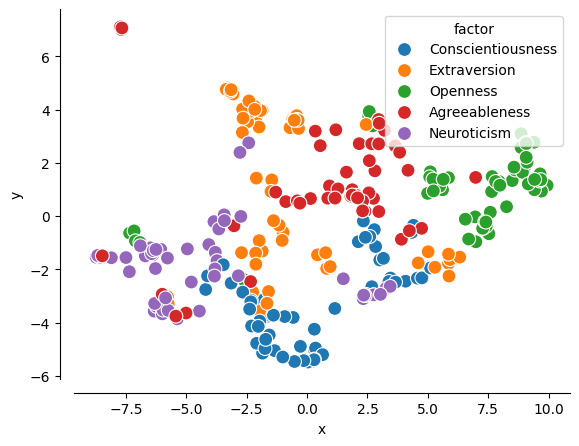

In [11]:
# Plot pac features
sns.scatterplot(data=pac_features, x='x', y='y', hue='factor', s=100)
sns.despine(offset=10)

As illustrated, the items somewhat cluster according to their factor, again suggesting that the extracted features have captured some meaningful information about the items.

## Bonus section: Reassigning Items to Constructs
Finally, we can ask how well the extracted features predict the constructs to which the items belong. We first extract the features for each construct.

In [12]:
# Extracting construct features
constructs = personality['construct'].unique()
# print(constructs)

# Extracting features for constructs
construct_features = model.encode(constructs)
# print(construct_features)

# Convert features to DataFrame
construct_features = pd.DataFrame(construct_features, index=constructs)
print(construct_features)

                                                0         1         2    \
Achievement-Striving                      -0.035535 -0.067479  0.016085   
Activity-Level                            -0.069989 -0.084962 -0.032387   
Adventurousness                           -0.013958 -0.043397 -0.002238   
Aesthetic Appreciation/Artistic Interests -0.002699  0.008492 -0.032319   
Altruism                                  -0.018067  0.019194  0.020959   
Anger                                      0.000035 -0.045015  0.005791   
Anxiety                                   -0.052146 -0.033044 -0.001035   
Assertiveness                              0.024796  0.029695  0.006306   
Cautiousness                              -0.017574 -0.037329 -0.002643   
Cheerfulness                              -0.040850 -0.003307 -0.011471   
Cooperation                               -0.005746 -0.018163  0.012534   
Depression                                -0.042942  0.005369 -0.007983   
Dutifulness              

The code next computes the cosine similarity between the construct features and the item features. 

In [13]:
# Computing cosine similarity between constructs and items
construct_item_sims = cosine_similarity(construct_features, item_features)
construct_sims = pd.DataFrame(construct_item_sims, index=construct_features.index, columns=item_features.index)
construct_sims

item,Go straight for the goal.,Plunge into tasks with all my heart.,Demand quality.,Set high standards for myself and others.,Turn plans into actions.,Do more than what's expected of me.,Work hard.,Do just enough work to get by.,Am not highly motivated to succeed.,Put little time and effort into my work.,...,Panic easily.,Get overwhelmed by emotions.,Feel that I'm unable to deal with things.,Can't make up my mind.,Become overwhelmed by events.,Remain calm under pressure.,Am calm even in tense situations.,Can handle complex problems.,Readily overcome setbacks.,Know how to cope.
Achievement-Striving,0.274946,0.241481,0.287819,0.333164,0.273771,0.287395,0.353840,0.261376,0.325640,0.232906,...,0.117919,0.080141,0.166343,0.150982,0.182212,0.173204,0.110393,0.176289,0.262112,0.104108
Activity-Level,0.150191,0.164223,0.170034,0.141714,0.287337,0.192487,0.227682,0.118596,0.217563,0.109019,...,0.160926,0.074866,0.247844,0.180831,0.166880,0.177309,0.141143,0.149842,0.203953,0.118545
Adventurousness,0.117201,0.202298,0.101796,0.071588,0.155783,0.115025,0.086260,0.091601,0.096149,0.044842,...,0.099970,0.042377,0.111607,0.105505,0.113231,0.112252,0.093814,0.152107,0.129980,0.128283
Aesthetic Appreciation/Artistic Interests,0.114738,0.141975,0.128617,0.083891,0.074965,0.112749,0.048860,0.075976,0.066372,0.077247,...,0.033825,0.106881,0.039243,0.054693,0.034033,0.016541,0.042317,0.146064,0.017504,0.050044
Altruism,0.081722,0.253159,0.085156,0.062599,0.051433,0.228921,0.168458,0.185049,0.071259,0.131811,...,0.030195,0.092541,0.071456,0.129707,0.062785,0.022226,0.030476,0.016200,0.026372,-0.005106
Anger,0.088293,0.041734,0.071665,0.000089,0.105484,0.121116,0.152621,0.167867,0.116108,0.141855,...,0.249201,0.260030,0.177441,0.160977,0.201047,0.219994,0.182023,0.102772,0.158591,0.163545
Anxiety,0.103641,0.002128,0.006200,0.009164,0.151527,0.053153,0.108204,0.103757,0.109374,0.116635,...,0.606866,0.492490,0.304101,0.288177,0.451945,0.449477,0.300566,0.198494,0.249858,0.317465
Assertiveness,0.222642,0.113944,0.231906,0.156470,0.222357,0.157459,0.246370,0.113975,0.150078,0.176826,...,0.212899,0.093350,0.164621,0.197566,0.192890,0.312723,0.232915,0.256845,0.294969,0.194898
Cautiousness,0.171891,0.134617,0.080357,0.106040,0.214292,0.140700,0.166193,0.150548,0.120177,0.133869,...,0.393790,0.198058,0.203146,0.263080,0.286704,0.291535,0.202012,0.169388,0.196266,0.168603
Cheerfulness,0.230914,0.175955,0.007100,0.062221,0.210912,0.150202,0.179123,0.146134,0.156510,0.103062,...,0.151701,0.162336,0.216732,0.176447,0.106473,0.166434,0.102937,0.029315,0.206970,0.194948


We then find the closest construct to each item by finding the construct with the highest similarity. We add this as a new column, `closest_construct`, to the `personality` dataframe.

In [14]:
# Finding the closest construct to each item adding as a new column ['closest_construct'] to the personality dataframe
closest_construct = construct_sims.idxmax()
closest_construct

item
Go straight for the goal.                    Achievement-Striving
Plunge into tasks with all my heart.                     Altruism
Demand quality.                              Achievement-Striving
Set high standards for myself and others.    Achievement-Striving
Turn plans into actions.                            Self-Efficacy
                                                     ...         
Remain calm under pressure.                               Anxiety
Am calm even in tense situations.                         Anxiety
Can handle complex problems.                            Intellect
Readily overcome setbacks.                          Self-Efficacy
Know how to cope.                                   Self-Efficacy
Length: 300, dtype: object

In [15]:
# Adding the closest constructs to original personality dataframe
personality['predicted_construct'] = personality['item'].map(closest_construct)
personality

,factor,construct,item,predicted_construct
0,Conscientiousness,Achievement-Striving,Go straight for the goal.,Achievement-Striving
1,Conscientiousness,Achievement-Striving,Plunge into tasks with all my heart.,Altruism
2,Conscientiousness,Achievement-Striving,Demand quality.,Achievement-Striving
3,Conscientiousness,Achievement-Striving,Set high standards for myself and others.,Achievement-Striving
4,Conscientiousness,Achievement-Striving,Turn plans into actions.,Self-Efficacy
...,...,...,...,...
295,Neuroticism,Vulnerability,Remain calm under pressure.,Anxiety
296,Neuroticism,Vulnerability,Am calm even in tense situations.,Anxiety
297,Neuroticism,Vulnerability,Can handle complex problems.,Intellect
298,Neuroticism,Vulnerability,Readily overcome setbacks.,Self-Efficacy


In [16]:
# Evaluating how well the predicted constructs align with the actual constructs
accuracy = (personality['construct'] == personality['predicted_construct']).mean()
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.45


Predicting the constructs based on the similarity between the item and construct features results in an accuracy of 23%. Whilst this is an improvement on the .03% accuracy that would be expected at random, it is still relatively low. This could suggest that the extracted features do not fully capture the differences between the constructs, or (perhaps more interestingly) that the constructs are not as distinct as we might expect.

You can also visualize the confusion matrix to see how well the items were assigned to the constructs. We firstly compute the confusion matrix using `pd.crosstab` and then sort it by the personality factor to make it easier to interpret. 

In [17]:
# Confusion matrix
confusion_matrix = pd.crosstab(personality['construct'], personality['predicted_construct'])

# Sorting confusion matrix by personality factor 
ordered_constructs = personality.sort_values('factor')['construct'].unique()
ordered_predicted_constructs = [construct for construct in ordered_constructs if construct in personality['predicted_construct'].unique()]
confusion_matrix = confusion_matrix.loc[ordered_constructs, ordered_predicted_constructs]
confusion_matrix

predicted_construct,Morality,Cooperation,Altruism,Modesty/Humility,Trust,Sympathy,Dutifulness,Cautiousness,Achievement-Striving,Orderliness,...,Self-consciousness,Anxiety,Depression,Anger,Adventurousness,Aesthetic Appreciation/Artistic Interests,Emotionality,Imagination,Liberalism,Intellect
construct,,,,,,,,,,,,,,,,,,,,,
Morality,1,0,5,1,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
Cooperation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,7,1,0,0,0,0,0
Altruism,0,0,4,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Modesty/Humility,0,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
Trust,1,0,0,0,7,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Sympathy,0,1,4,0,0,3,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
Dutifulness,0,0,0,0,0,0,1,0,0,3,...,0,0,0,0,0,0,0,0,0,0
Cautiousness,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,3,0,0,0,0,0
Achievement-Striving,0,0,1,0,0,0,0,0,7,0,...,0,0,0,0,0,0,0,0,0,0


When interpreting the confusion matrix, it is important to remember that the rows represent the actual constructs, while the columns represent the predicted constructs. The values in the cells represent the number of items assigned to each construct. The diagonal reflects the number of items "correctly" (i.e, according to experts) assigned to their construct, while off-diagonal values reflect items that were misclassified. Finally, the maximum number of items that could be correctly assigned to a construct is 10, which is why the heatmap is capped at this value. 

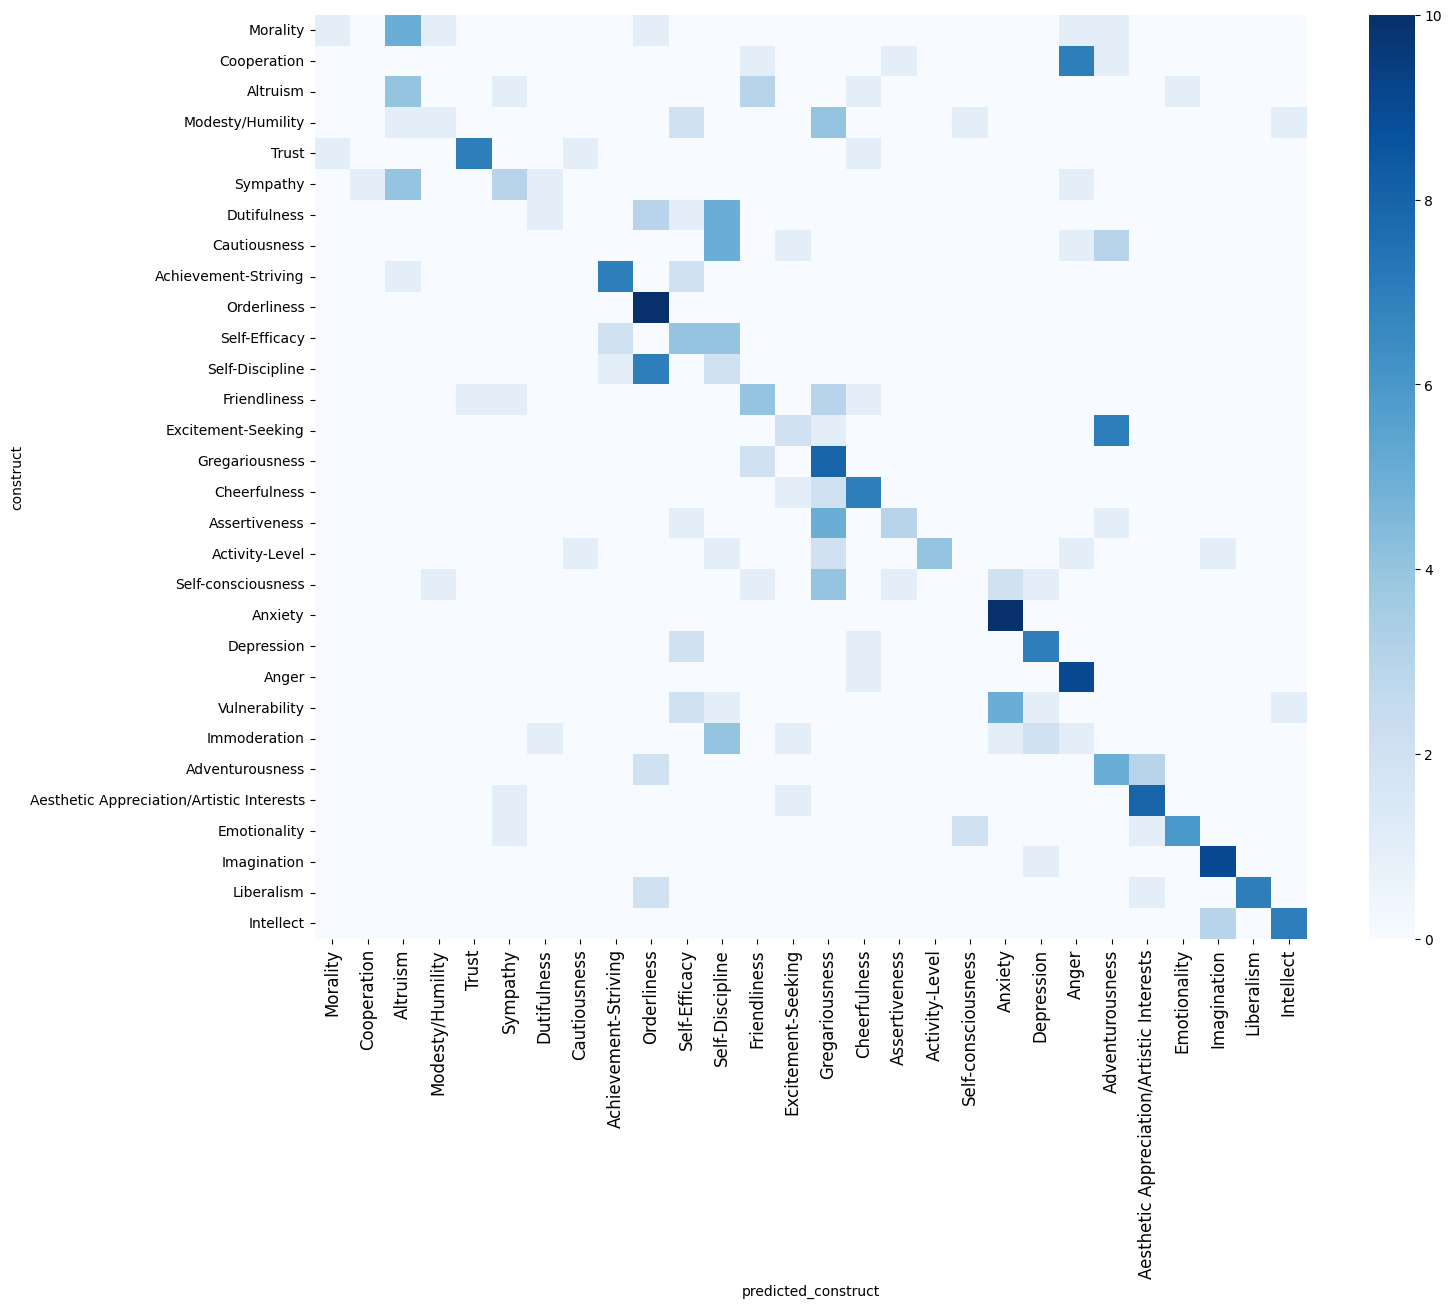

In [18]:
# Plotting confusion matrix without numbers in cells
fig, ax = plt.subplots(figsize=(16, 12))
n_items_per_construct = 10 # Maximum possible number of correctly assigned items per construct
sns.heatmap(confusion_matrix, cmap='Blues', vmin=0, vmax=n_items_per_construct, ax=ax)

# Increasing x-tick label and y-tick label font size
ax.xaxis.set_tick_params(labelsize=12)

As illustrated, while some constructs are well predicted (e.g., "Emotionality" and "Imagination"), most are less well predicted. 

**TASK**: Now rerun the entire notebook but with `model = SentenceTransformer('dwulff/mpnet-personality')` (you can find the right line via a `cmd + f` search). This is a model that has been fine-tuned on pairs of personality items to accurately predict the observed correlations between items. Although performance should be considerably better, it is important to be aware that this model has been fine-tuned on the same data that we are using to evaluate it, which gives it an unfair advantage.

# Example code
from: https://huggingface.co/dwulff/mpnet-personality

In [19]:
from sentence_transformers import SentenceTransformer

# personality sentences
sentences = ["Rarely think about how I feel.", "Make decisions quickly."]

# load model
model = SentenceTransformer('dwulff/mpnet-personality')

# extract embeddings
embeddings = model.encode(sentences)
print(embeddings)


[[-0.0382      0.02641887  0.06555929 ...  0.03106362 -0.04581135
  -0.00398522]
 [-0.03133777 -0.01612343  0.01217051 ... -0.02164336 -0.03136001
   0.03583631]]
